In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

celestenuez_frutas_path = kagglehub.dataset_download('celestenuez/frutas')
celestenuez_img_prueba_path = kagglehub.dataset_download('celestenuez/img-prueba')

print('Data source import complete.')


In [ ]:
# Clasificador de Frutas - Versión Mejorada con ResNet34 y Augmentations

import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.models import resnet34

In [ ]:
# ----------------------------
# 1. Preparación del Dataset
# ----------------------------
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),                      # ⬆️ Cambio: aumento de resolución de 100x100 a 224x224
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # ➕ Aumento de datos
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],     # ➕ Normalización
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("/kaggle/input/frutas/frutas/Training", transform=transform_train)
test_dataset = datasets.ImageFolder("/kaggle/input/frutas/frutas/Test", transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# ----------------------------
# 2. Inicialización del Modelo
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet34(weights="IMAGENET1K_V1")                # ⬆️ Cambio: se usa ResNet34 en lugar de ResNet18
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 197MB/s] 


In [ ]:
# ----------------------------
# 3. Entrenamiento
# ----------------------------
train_losses = []
val_accuracies = []

for epoch in range(5):  # ⬆️ Puedes aumentar a 10+ según tiempo/disponibilidad
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    val_accuracies.append(acc)
    print(f"Epoch {epoch+1} | Loss: {train_losses[-1]:.4f} | Accuracy: {acc:.2f}%")



Epoch 1 | Loss: 0.2626 | Accuracy: 94.01%
Epoch 2 | Loss: 0.0916 | Accuracy: 94.37%
Epoch 3 | Loss: 0.0598 | Accuracy: 98.12%
Epoch 4 | Loss: 0.0444 | Accuracy: 98.12%
Epoch 5 | Loss: 0.0406 | Accuracy: 99.29%


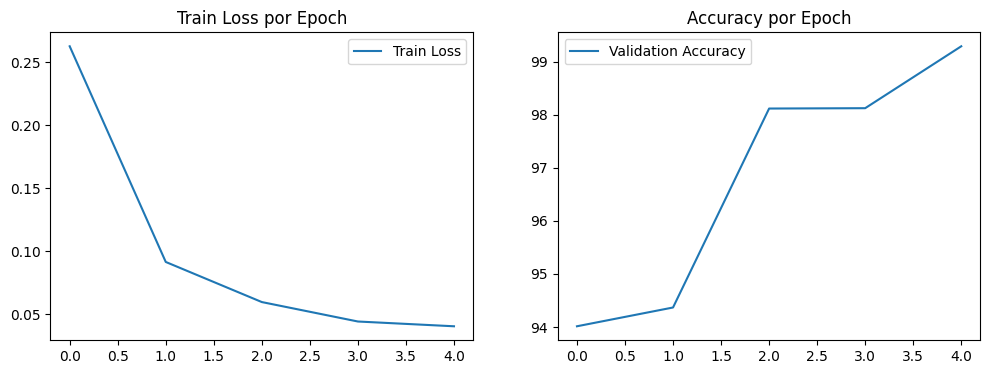

In [ ]:
# 4. Gráfico de resultados
# ----------------------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Train Loss por Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy por Epoch")
plt.legend()
plt.show()

# ----------------------------



📉 Train Loss por Epoch
La curva de pérdida de entrenamiento disminuye de manera constante y rápida.

Comienza alrededor de 0.26 y cae por debajo de 0.05.

🔍 Interpretación: el modelo está aprendiendo bien, sin señales claras de overfitting ni estancamiento.

📈 Validation Accuracy por Epoch
La precisión de validación comienza en ~94% y sube hasta 98.8%.

Se estabiliza en un rango alto (>97%), lo cual es excelente.

🔍 Interpretación: el modelo generaliza bien y no está sobreajustado al set de entrenamiento.



In [ ]:
# 5. Guardado
# ----------------------------
torch.save(model, "modelo_resnet34.pth")
print("✅ Modelo guardado como modelo_resnet34.pth")

✅ Modelo guardado como modelo_resnet34.pth


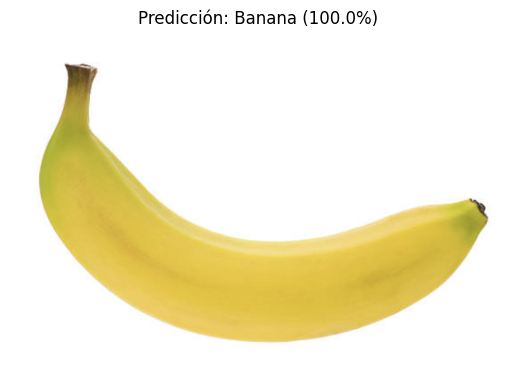

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Ruta a la imagen externa
ruta_imagen = "/kaggle/input/img-prueba/img_prueba/001.png"  # Cambiá según tu imagen

# Cargar y transformar la imagen
imagen = Image.open(ruta_imagen).convert("RGB")
entrada = transform_test(imagen).unsqueeze(0).to(device)  # ✅ usar transform_test

# Predicción
model.eval()
with torch.no_grad():
    salida = model(entrada)
    probs = torch.nn.functional.softmax(salida, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()
    confianza = torch.max(probs).item() * 100

# Mostrar resultado
plt.imshow(imagen)
plt.axis("off")
plt.title(f"Predicción: {train_dataset.classes[pred_idx]} ({confianza:.1f}%)")
plt.show()


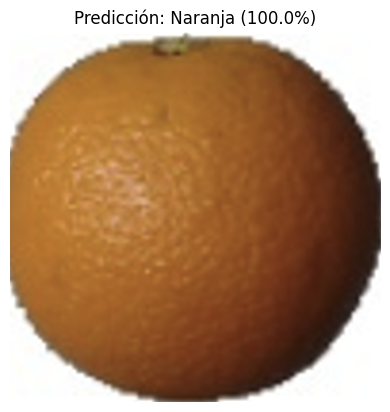

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Ruta a la imagen externa
ruta_imagen = "/kaggle/input/img-prueba/img_prueba/Captura de pantalla 2025-05-28 093250.png"  # Cambiá según tu imagen

# Cargar y transformar la imagen
imagen = Image.open(ruta_imagen).convert("RGB")
entrada = transform_test(imagen).unsqueeze(0).to(device)  # ✅ usar transform_test

# Predicción
model.eval()
with torch.no_grad():
    salida = model(entrada)
    probs = torch.nn.functional.softmax(salida, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()
    confianza = torch.max(probs).item() * 100

# Mostrar resultado
plt.imshow(imagen)
plt.axis("off")
plt.title(f"Predicción: {train_dataset.classes[pred_idx]} ({confianza:.1f}%)")
plt.show()


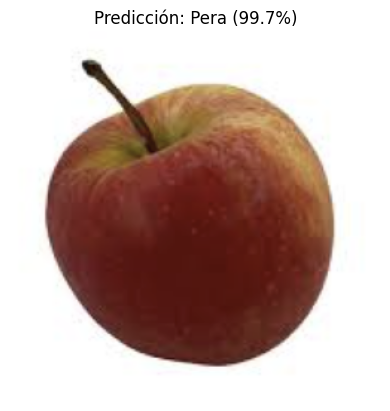

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Ruta a la imagen externa
ruta_imagen = "/kaggle/input/img-prueba/img_prueba/Captura de pantalla 2025-06-10 235631.png"  # Cambiá según tu imagen

# Cargar y transformar la imagen
imagen = Image.open(ruta_imagen).convert("RGB")
entrada = transform_test(imagen).unsqueeze(0).to(device)  # ✅ usar transform_test

# Predicción
model.eval()
with torch.no_grad():
    salida = model(entrada)
    probs = torch.nn.functional.softmax(salida, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()
    confianza = torch.max(probs).item() * 100

# Mostrar resultado
plt.imshow(imagen)
plt.axis("off")
plt.title(f"Predicción: {train_dataset.classes[pred_idx]} ({confianza:.1f}%)")
plt.show()


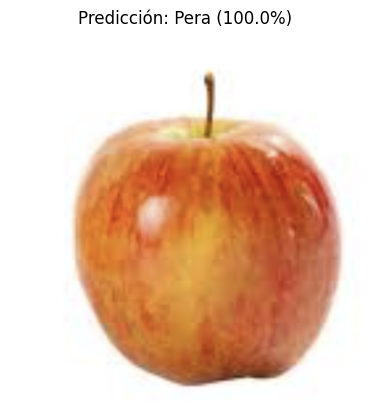

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Ruta a la imagen externa
ruta_imagen = "/kaggle/input/img-prueba/img_prueba/Captura de pantalla 2025-06-10 235450.png"  # Cambiá según tu imagen

# Cargar y transformar la imagen
imagen = Image.open(ruta_imagen).convert("RGB")
entrada = transform_test(imagen).unsqueeze(0).to(device)  # ✅ usar transform_test

# Predicción
model.eval()
with torch.no_grad():
    salida = model(entrada)
    probs = torch.nn.functional.softmax(salida, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()
    confianza = torch.max(probs).item() * 100

# Mostrar resultado
plt.imshow(imagen)
plt.axis("off")
plt.title(f"Predicción: {train_dataset.classes[pred_idx]} ({confianza:.1f}%)")
plt.show()


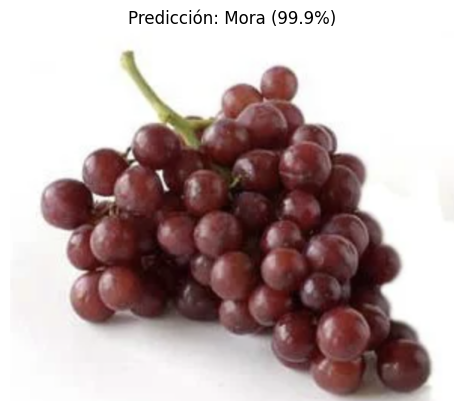

In [ ]:

from PIL import Image
import matplotlib.pyplot as plt

# Ruta a la imagen externa
ruta_imagen = "/kaggle/input/img-prueba/img_prueba/Captura de pantalla 2025-06-10 235205.png"  # Cambiá según tu imagen

# Cargar y transformar la imagen
imagen = Image.open(ruta_imagen).convert("RGB")
entrada = transform_test(imagen).unsqueeze(0).to(device)  # ✅ usar transform_test

# Predicción
model.eval()
with torch.no_grad():
    salida = model(entrada)
    probs = torch.nn.functional.softmax(salida, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()
    confianza = torch.max(probs).item() * 100

# Mostrar resultado
plt.imshow(imagen)
plt.axis("off")
plt.title(f"Predicción: {train_dataset.classes[pred_idx]} ({confianza:.1f}%)")
plt.show()


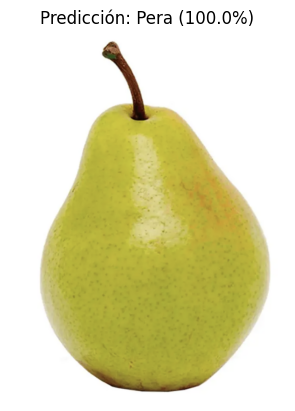

In [ ]:

from PIL import Image
import matplotlib.pyplot as plt

# Ruta a la imagen externa
ruta_imagen = "/kaggle/input/img-prueba/img_prueba/Captura de pantalla 2025-06-10 235049.png"  # Cambiá según tu imagen

# Cargar y transformar la imagen
imagen = Image.open(ruta_imagen).convert("RGB")
entrada = transform_test(imagen).unsqueeze(0).to(device)  # ✅ usar transform_test

# Predicción
model.eval()
with torch.no_grad():
    salida = model(entrada)
    probs = torch.nn.functional.softmax(salida, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()
    confianza = torch.max(probs).item() * 100

# Mostrar resultado
plt.imshow(imagen)
plt.axis("off")
plt.title(f"Predicción: {train_dataset.classes[pred_idx]} ({confianza:.1f}%)")
plt.show()


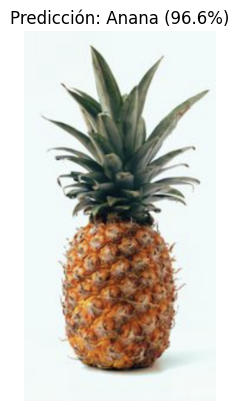

In [ ]:

from PIL import Image
import matplotlib.pyplot as plt

# Ruta a la imagen externa
ruta_imagen = "/kaggle/input/img-prueba/img_prueba/Captura de pantalla 2025-06-10 234509.png"  # Cambiá según tu imagen

# Cargar y transformar la imagen
imagen = Image.open(ruta_imagen).convert("RGB")
entrada = transform_test(imagen).unsqueeze(0).to(device)  # ✅ usar transform_test

# Predicción
model.eval()
with torch.no_grad():
    salida = model(entrada)
    probs = torch.nn.functional.softmax(salida, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()
    confianza = torch.max(probs).item() * 100

# Mostrar resultado
plt.imshow(imagen)
plt.axis("off")
plt.title(f"Predicción: {train_dataset.classes[pred_idx]} ({confianza:.1f}%)")
plt.show()


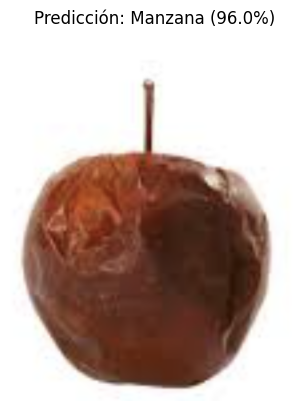

In [ ]:

from PIL import Image
import matplotlib.pyplot as plt

# Ruta a la imagen externa
ruta_imagen = "/kaggle/input/img-prueba/img_prueba/Captura de pantalla 2025-06-10 235441.png"  # Cambiá según tu imagen

# Cargar y transformar la imagen
imagen = Image.open(ruta_imagen).convert("RGB")
entrada = transform_test(imagen).unsqueeze(0).to(device)  # ✅ usar transform_test

# Predicción
model.eval()
with torch.no_grad():
    salida = model(entrada)
    probs = torch.nn.functional.softmax(salida, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()
    confianza = torch.max(probs).item() * 100

# Mostrar resultado
plt.imshow(imagen)
plt.axis("off")
plt.title(f"Predicción: {train_dataset.classes[pred_idx]} ({confianza:.1f}%)")
plt.show()
